In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

table_hk_daily = "hk_customs_sum_daily"
table_hk_monthly = "hk_customs_sum_monthly"
table_sh_monthly = "sh_customs"
table_hk_selected = "hk_customs_daily_selected"

database_url = "sqlite:///../data/data.sqlite"

# 创建数据库引擎
engine = create_engine(database_url)

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS
from pypots.utils.metrics import calc_mae



# Data preprocessing. Tedious, but PyPOTS can help.
query = f"SELECT * FROM {table_hk_selected}"
df = pd.read_sql_query(query,engine)  # PyPOTS will automatically download and extract it.
for column in df.columns:
    if column not in ['date']:
        df[column] = StandardScaler().fit_transform(df[column].values.reshape(-1, 1)).reshape(-1)
# 确保日期列是日期时间类型
df['date'] = pd.to_datetime(df['date'])
# 创建一个完整的日期范围
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())
# 使用reindex填充缺失的日期
df.set_index('date', inplace=True)  # 设置日期列为索引
df = df.reindex(date_range).rename_axis('date').reset_index()  # 重建索引，填充缺失的日期
num_samples = len(df['date'].unique())

2024-02-22 11:53:12 [ERROR]: ❌ No module named 'torch_geometric'
Note torch_geometric is missing, please install it with 'pip install torch_geometric torch_scatter torch_sparse' or 'conda install -c pyg pyg pytorch-scatter pytorch-sparse'
2024-02-22 11:53:12 [ERROR]: ❌ name 'MessagePassing' is not defined
Note torch_geometric is missing, please install it with 'pip install torch_geometric torch_scatter torch_sparse' or 'conda install -c pyg pyg pytorch-scatter pytorch-sparse'


In [40]:
df
print(df['global_airport_entry'].values.shape)

(1783,)


In [29]:
X = df.drop(columns=['date']).values  # drop date column
X = X.reshape(1, num_samples, -1)
X_ori = X  # keep X_ori for validation

# X = mcar(X, 0.1)  # randomly hold out 10% observed values as ground truth
dataset = {"X": X}  # X for model input
print(X.shape)  # (11988, 48, 37), 11988 samples, 48 time steps, 37 features

(1, 1783, 4)


In [30]:
# Model training. This is PyPOTS showtime.
saits = SAITS(n_steps=1783, n_features=4, n_layers=4, d_model=128, d_inner=128, n_heads=4, d_k=32, d_v=64, dropout=0.1, epochs=10)
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
saits.fit(dataset)
imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation
# mae = calc_mae(imputation, np.nan_to_num(X_ori), indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)

2024-02-22 12:12:03 [INFO]: No given device, using default device: cpu
2024-02-22 12:12:03 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2024-02-22 12:12:03 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,065,228
2024-02-22 12:13:20 [INFO]: Epoch 001 - training loss: 1.9152
2024-02-22 12:14:09 [INFO]: Epoch 002 - training loss: 1.5874
2024-02-22 12:14:56 [INFO]: Epoch 003 - training loss: 1.5108
2024-02-22 12:15:39 [INFO]: Epoch 004 - training loss: 1.3119
2024-02-22 12:16:34 [INFO]: Epoch 005 - training loss: 1.2747
2024-02-22 12:17:24 [INFO]: Epoch 006 - training loss: 1.1425
2024-02-22 12:18:11 [INFO]: Epoch 007 - training loss: 1.0601
2024-02-22 12:19:27 [INFO]: Epoch 008 - training loss: 0.9562
2024-02-22 12:20:21 [INFO]: Epoch 009 - training loss: 0.8889
2024-02-22 12:21:04 [INFO]: Epoch 010 - training loss: 0.8971
2024-02-22 12:21:04 [INFO]: Finished training.
2024-02-22 12:21:04 [WARNING]

In [35]:

imputation.shape

(1, 1783, 4)

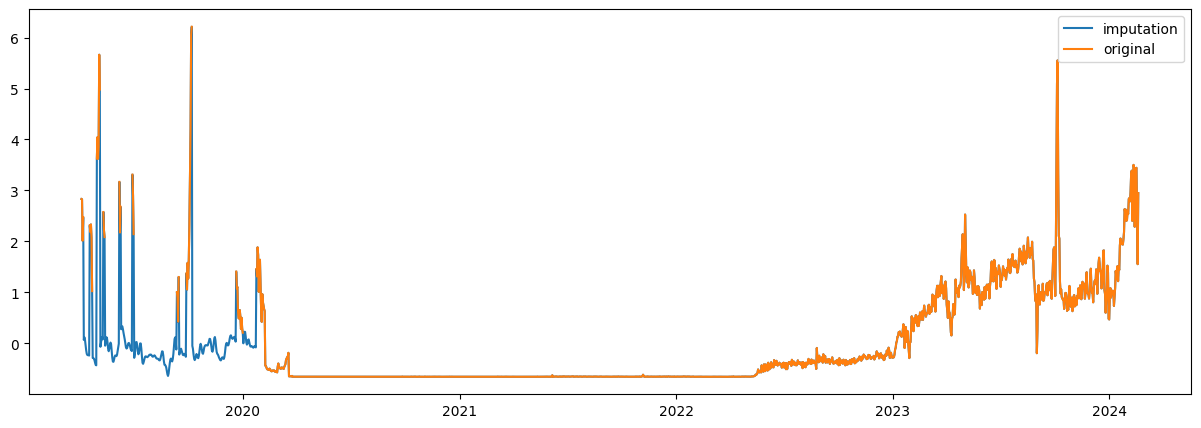

In [51]:
from matplotlib import pyplot as plt

imputation_val = pd.DataFrame(imputation.reshape(1783,4), columns=df.columns[1:])
imputation_val['date'] = df['date']

# draw the imputation result
plt.figure(figsize=(15, 5))
plt.plot(imputation_val['date'], imputation_val['global_airport_entry'], label='imputation')
plt.plot(df['date'], df['global_airport_entry'], label='original')
plt.legend()
plt.show()